In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-06-04 04:13:22--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  1.33MB/s    in 0.2s    

2025-06-04 04:13:23 (1.33 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    if p.grad is not None:
      p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000 : 3.3221
  10000/ 200000 : 2.1877
  20000/ 200000 : 2.4270
  30000/ 200000 : 2.6032
  40000/ 200000 : 2.0712
  50000/ 200000 : 2.4562
  60000/ 200000 : 2.4073
  70000/ 200000 : 2.1389
  80000/ 200000 : 2.3659
  90000/ 200000 : 2.0872
 100000/ 200000 : 1.8262
 110000/ 200000 : 2.2224
 120000/ 200000 : 1.8486
 130000/ 200000 : 2.5117
 140000/ 200000 : 2.1848
 150000/ 200000 : 2.1080
 160000/ 200000 : 1.9327
 170000/ 200000 : 1.8609
 180000/ 200000 : 2.0279
 190000/ 200000 : 1.8963


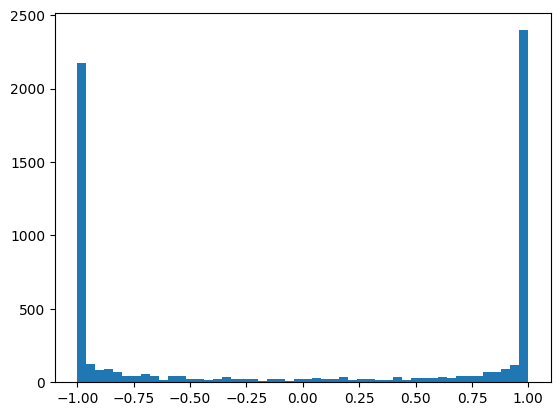

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

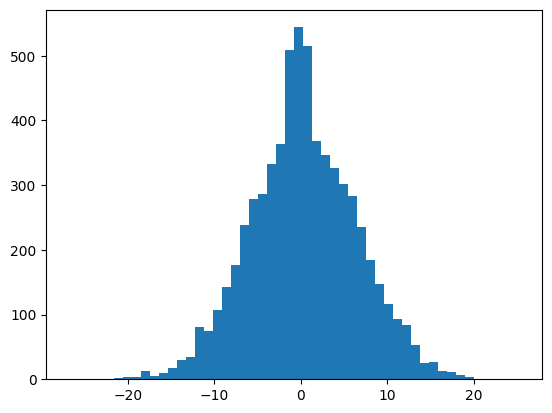

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

The problem is between sharp +1, -1 values. Essentially if the value abs(1) is fed to the activation(which in this case is happening), that neuron is never activated in the first place... which simply translates that the neural network doesnt learn anything for that particular neuron. In the graph below it is obeservable that for the white spaces the network does not learn anything. We want to avoid that of any activation function, not just `tanh`

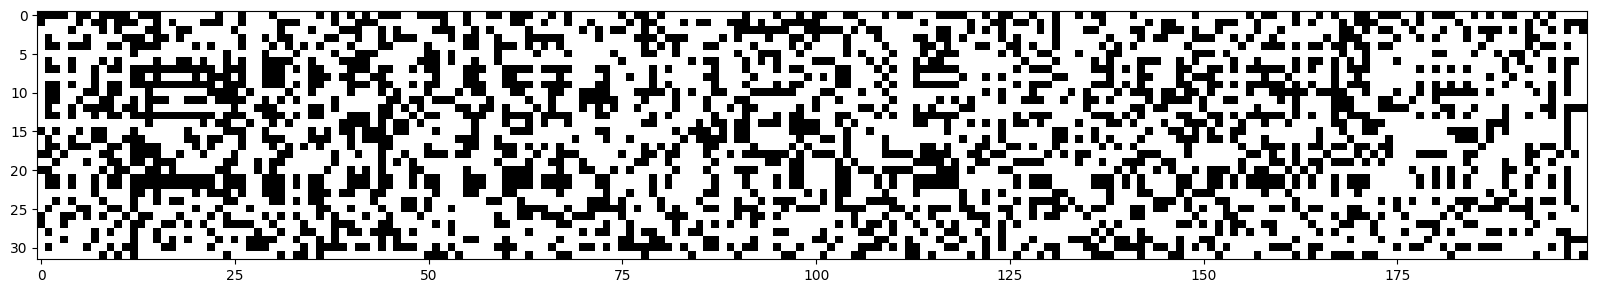

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap = 'grey', interpolation = 'nearest')

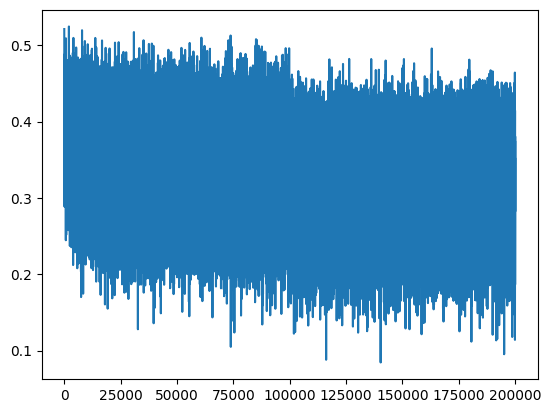

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train' : (Xtr, Ytr),
      'val' : (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  h = torch.tanh(embcat @ W1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.391929864883423
val 2.438176155090332


In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
ndalyah.
ren.
rucendraegusterronelin.
shi.
jen.
eden.
est.
aarvelyzion.
kamin.
shub.
roshirael.
kin.
renlynn.
novana.
ubelled.
ryyah.
fael.


# Fixing the activation problem

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # Minibatch Construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # Forward Pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Liner Layer
  hpreact = embcat @ W1 # + b1 # hidden layer pre-activation

  # BatchNorm Layer
  # -----------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -----------------------------------------------------------

  # Non-linearity
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    if p.grad is not None:
      p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000 : 2.0897
  10000/ 200000 : 2.2439
  20000/ 200000 : 2.3723
  30000/ 200000 : 1.6809
  40000/ 200000 : 2.1602
  50000/ 200000 : 2.5532
  60000/ 200000 : 1.7971
  70000/ 200000 : 2.1239
  80000/ 200000 : 2.3099
  90000/ 200000 : 2.1732
 100000/ 200000 : 2.3096
 110000/ 200000 : 2.0885
 120000/ 200000 : 2.7519
 130000/ 200000 : 2.2173
 140000/ 200000 : 2.2514
 150000/ 200000 : 2.2763
 160000/ 200000 : 2.1563
 170000/ 200000 : 2.1331
 180000/ 200000 : 2.1791
 190000/ 200000 : 2.0036


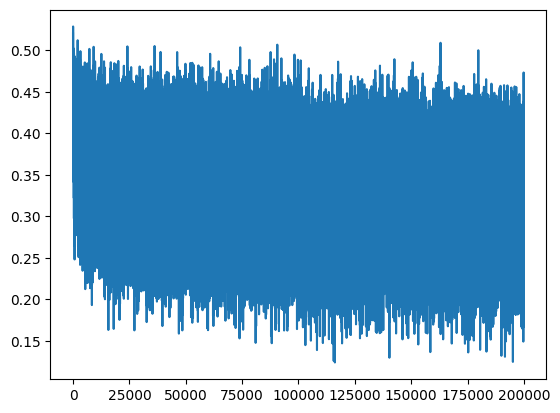

In [ ]:
plt.plot(lossi)

In [ ]:
# Calibrated batch norm at the end of training

with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

# No need of this as we performed this in parallel with training (bnmean_running & bnstd_running)

In [ ]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train' : (Xtr, Ytr),
      'val' : (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.1049270629882812


In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

briangmyazziyes.
bdulyah.
briyas.
brdrner.
sherkodrlithlyllsenleigh.
santhannchyziohmkrrnn.
shdumrishimnest.
jadestly.
prgbdulfuubdgghder.
jaquezmashburjahsis.
dashby.
sadya.
sus.
zakquslutel.
subristia.
sumprrdnn.
quloeonandphillsamreyxa.
hunton.
bdasirfalvinnwrllwildtalfr.
tandysestss.


# Torch usage to implement above

In [ ]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in * 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.zeros(dim)
    self.beta = torch.ones(dim)
    # buffers (trained with a running `momentum update`)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch var
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize the unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

n_embd = 10 # the dimentionality of the chars embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight += 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # Minibatch Construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # Forward Pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # Backward Pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000 : 3.2937
  10000/ 200000 : 2.6263
  20000/ 200000 : 2.7123
  30000/ 200000 : 2.4734
  40000/ 200000 : 2.2328
  50000/ 200000 : 2.4855
  60000/ 200000 : 2.1725
  70000/ 200000 : 2.3367
  80000/ 200000 : 2.0817
  90000/ 200000 : 2.1742
 100000/ 200000 : 2.4310
 110000/ 200000 : 2.1000
 120000/ 200000 : 2.2932
 130000/ 200000 : 2.0929
 140000/ 200000 : 1.9445
 150000/ 200000 : 2.1561
 160000/ 200000 : 2.4503
 170000/ 200000 : 2.3037
 180000/ 200000 : 2.3626
 190000/ 200000 : 2.2031


layer 1 (      Tanh): mean +0.03, std 0.64, saturated: 17.50%
layer 3 (      Tanh): mean -0.02, std 0.67, saturated: 11.38%
layer 5 (      Tanh): mean +0.01, std 0.68, saturated: 12.59%
layer 7 (      Tanh): mean -0.00, std 0.60, saturated: 15.66%
layer 9 (      Tanh): mean +0.02, std 0.48, saturated: 9.69%


Text(0.5, 1.0, 'activation distribution')

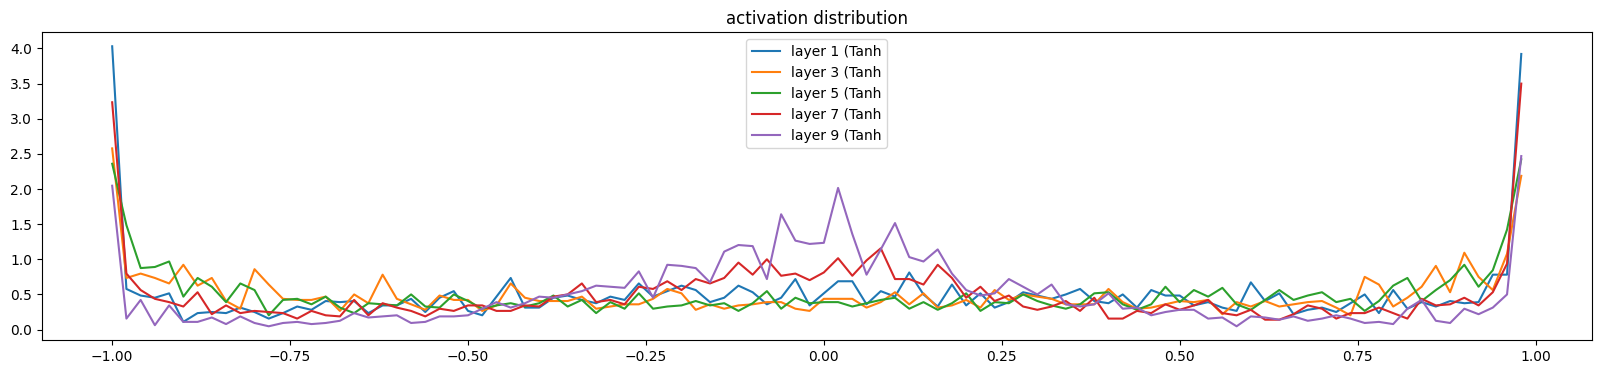

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000135, std 6.272799e-03
layer 3 (      Tanh): mean +0.000020, std 4.025531e-03
layer 5 (      Tanh): mean -0.000027, std 3.235412e-03
layer 7 (      Tanh): mean -0.000059, std 4.747901e-03
layer 9 (      Tanh): mean -0.000162, std 6.202886e-03


Text(0.5, 1.0, 'gradient distribution')

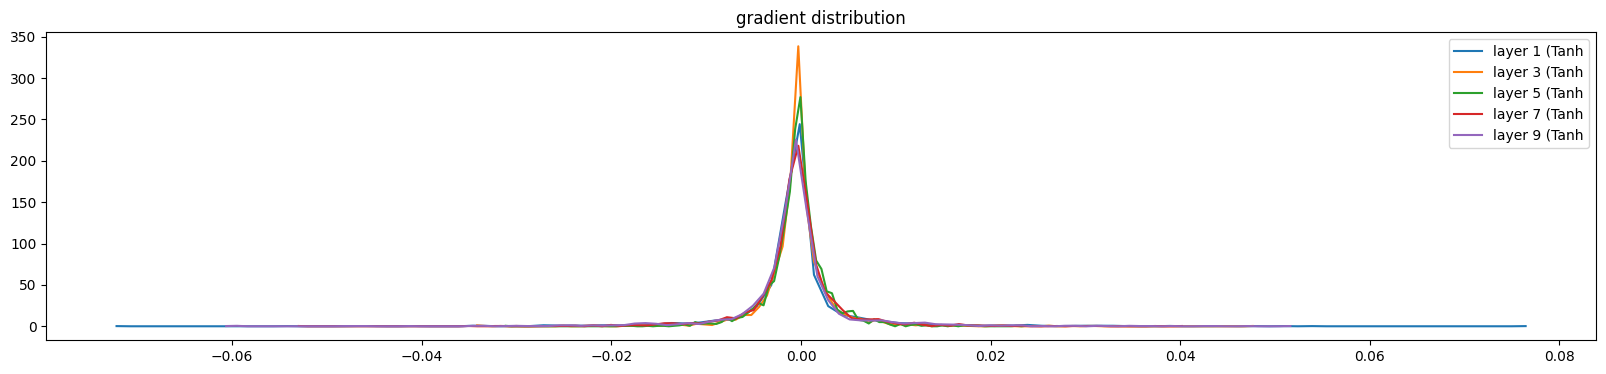

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000772 | std 2.210779e-02 | grad:data ratio 1.911925e-02
weight  (30, 100) | mean +0.000235 | std 1.525813e-02 | grad:data ratio 5.159713e-02
weight (100, 100) | mean +0.000031 | std 6.939033e-03 | grad:data ratio 6.253151e-02
weight (100, 100) | mean -0.000024 | std 6.762361e-03 | grad:data ratio 8.200159e-02
weight (100, 100) | mean +0.000061 | std 7.792067e-03 | grad:data ratio 9.200051e-02
weight (100, 100) | mean +0.000048 | std 8.051221e-03 | grad:data ratio 8.158047e-02
weight  (100, 27) | mean -0.000000 | std 1.409721e-02 | grad:data ratio 6.594927e-02


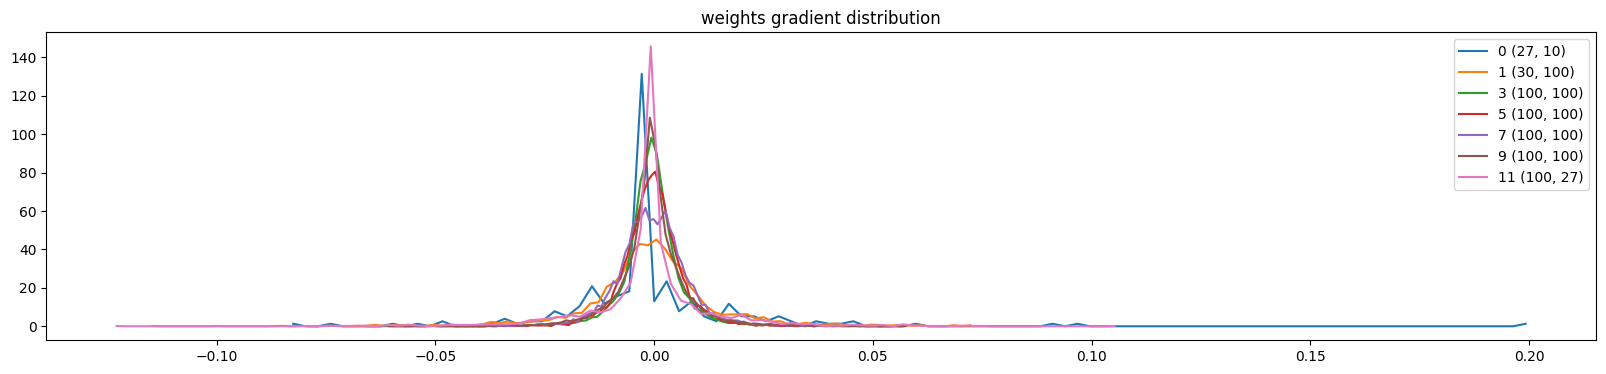

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');